Using backend: pytorch


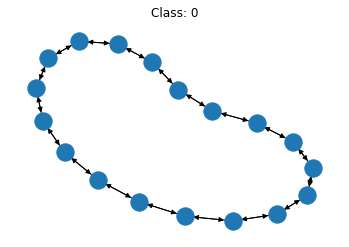

cuda


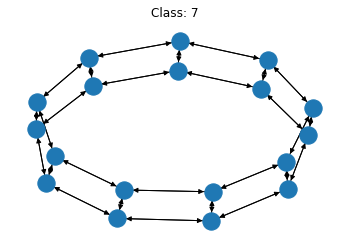

DGLGraph(num_nodes=18, num_edges=72,
         ndata_schemes={}
         edata_schemes={}) 7
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[1, 9, 8, 0, 2, 10, 1, 3, 11, 2, 4, 12, 3, 5, 13, 4, 6, 14, 5, 7, 15, 6, 8, 16, 7, 17, 0, 10, 0, 17, 9, 11, 1, 10, 12, 2, 11, 13, 3, 12, 14, 4, 13, 15, 5, 14, 16, 6, 15, 17, 7, 16, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
tensor([-5.2739,  5.0592], device='cuda:0', grad_fn=<AddBackward0>)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric 
from torch_geometric.datasets import GeometricShapes
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric.utils as pygutils
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

from gnnexplainer.GNNExplainer import GNNExplainer
# from torch_geometric.nn import  GNNExplainer


import dgl.function as fn
import torch
import torch.nn as nn


class Net(torch.nn.Module):
    def __init__(self,in_dim, hidden_dim, n_classes):
        super(Net, self).__init__()
#         self.lin = Sequential(Linear(10, 10))
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, x, edge_index):
        h1 = F.relu(self.conv1(x, edge_index))
#         h2 = F.dropout(h1, training=self.training)
        h3 = F.relu(self.conv2(h1, edge_index))
        y = torch.max(h3, 0).values
        return self.classify(y)
    
    

# A dataset with 80 samples, each graph is
# of size [10, 20]
trainset = MiniGCDataset(600, 12, 20)
testset = MiniGCDataset(60, 12, 20)
graph, label = trainset[55]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

train_data_loader = DataLoader(trainset, batch_size=1, shuffle=True,collate_fn=collate)

traindata=[]
for iter, (g,label) in enumerate(train_data_loader):
    if(label == 5):
        traindata.append((g,0))
    if(label == 7):
        traindata.append((g,1)) 
training_epoch = 100 #original = 1500 for 1 training sample 500 for 20 samples
initial_lr = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'explain_graph_MaxNet_epoch100'
SAVE_PATH = './models/' + model_name
model = Net(1, 256, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr = initial_lr,weight_decay=5e-4)
# optimizer = optim.SGD(model.parameters(), lr = initial_lr, momentum=0.9, weight_decay=5e-4)
training = 'Continue'
if(training == 'New'):
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H:%M:%S")
    model_name = 'explaingraph_epoch{}'.format(training_epoch)+timestampStr
if(training=='Continue'):
    checkpoint = torch.load(SAVE_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    # loss = checkpoint['loss']
    print(device)
    training=''

    
test_g,label = testset[55]

fig, ax = plt.subplots()
nx.draw(test_g.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()
print(test_g,label)
label = 0
x = test_g.in_degrees().view(-1, 1).float().cuda()
# x = feature
a = test_g.edges()[0].tolist()
print(a)

b = test_g.edges()[1].tolist()
print(b)
edges= list(zip(a,b))
edges=np.array(edges)
edges=torch.LongTensor(edges.transpose()).cuda()
probs_Y = model(x, edges)
print(probs_Y)

from tensorboardX import SummaryWriter
writer = SummaryWriter()
explainer = GNNExplainer(model, epochs=2000,lr=0.1,writer=writer)

Predicted label: tensor([1])
Learning rate: 0.1


RuntimeError: Function AddBackward0 returned an invalid gradient at index 1 - expected type TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false) but got TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false) (validate_outputs at /opt/conda/conda-bld/pytorch_1587428207430/work/torch/csrc/autograd/engine.cpp:484)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x4e (0x7f0b7c3d7b5e in /home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x2ae2834 (0x7f0b4aadc834 in /home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #2: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x548 (0x7f0b4aade368 in /home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #3: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7f0b4aae02f2 in /home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #4: torch::autograd::Engine::thread_init(int) + 0x39 (0x7f0b4aad8969 in /home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #5: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7f0b4dc179f8 in /home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #6: <unknown function> + 0xc819d (0x7f0b8746819d in /home/gpu-user-02/anaconda3/envs/pytorch/bin/../lib/libstdc++.so.6)
frame #7: <unknown function> + 0x76db (0x7f0b8b1126db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #8: clone + 0x3f (0x7f0b8ae3b88f in /lib/x86_64-linux-gnu/libc.so.6)


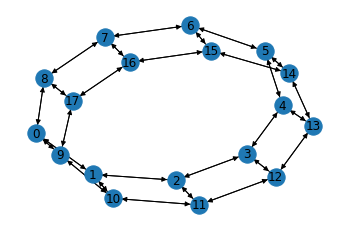

In [2]:
from math import sqrt

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
import numpy as np
EPS = 1e-15

fig, ax = plt.subplots()
G=test_g.to_networkx()
pos = nx.spring_layout(G)
nx.draw(G,pos,ax=ax)
# nx.draw_networkx_nodes(G, pos,ax=ax)
nx.draw_networkx_labels(G, pos)

edge_mask,node_feat_mask,epoch_losses = explainer.explain_graph(x=x, edge_index=edges)

plt = explainer.visualize_subgraph(None,edge_index=edges, edge_mask=edge_mask,threshold=0.1)
plt.show()



In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()
# print(node_feat_mask)
print(edge_mask)
print(edges[0,edge_mask>0.2])
print(edges[1,edge_mask>0.2])



In [ ]:
plt = explainer.visualize_subgraph(None,edge_index=edges, edge_mask=edge_mask,threshold=0.3)
plt.show()